# Investigating alignment
In {doc}`./bilateral_symmetry`, we saw how odd some of the embedding alignments can
be, and how large of an effect they have on downstream analysis.

Here, we investigate some of these embedding alignments in more detail. In summary, we
will:
- Look at the known pairs and how they compare to pairs that we'd predict via graph
  matching. We will also try using the graph-matching-predicted pairs as the vertex
  correspondence for Procrustes matching
- Try using Omni instead of ASE to embed
- Try removing the paired Kenyon cells from this analysis to see whether they have
  much effect on the alignments above.

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import (
    AdjacencySpectralEmbed,
    OmnibusEmbed,
    select_dimension,
)
from graspologic.match import GraphMatch
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import load_maggot_graph, load_palette
from pkg.io import savefig
from pkg.plot import set_theme


from src.visualization import adjplot  # TODO fix graspologic version and replace here

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "align_investigation"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
palette = dict(zip(["Left", "Right"], colors))
set_theme()

## Load and process data

1144 in intersection of largest connected components.


(<Figure size 1080x504 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Left $\\to$ left'}>,
        <AxesSubplot:title={'center':'Right $\\to$ right'}>], dtype=object))

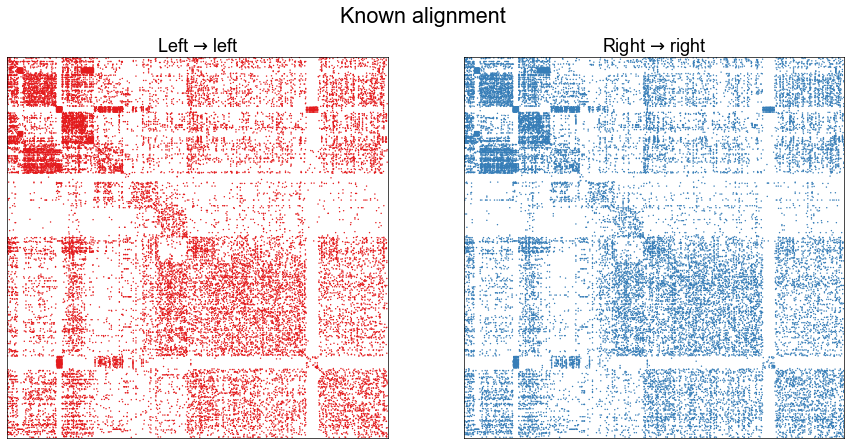

In [2]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]

ll_mg, rr_mg, lr_mg, rl_mg = mg.bisect(paired=True)

ll_adj = ll_mg.sum.adj.copy()
rr_adj = rr_mg.sum.adj.copy()

nodes = ll_mg.nodes
nodes["_inds"] = range(len(nodes))
sorted_nodes = nodes.sort_values(["simple_group"])
sort_inds = sorted_nodes["_inds"]

ll_adj = ll_adj[np.ix_(sort_inds, sort_inds)]
rr_adj = rr_adj[np.ix_(sort_inds, sort_inds)]

adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")


def plot_adjs(left, right, title=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    adjplot(
        left,
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[0],
        title=r"Left $\to$ left",
        color=palette["Left"],
    )
    adjplot(
        right,
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[1],
        title=r"Right $\to$ right",
        color=palette["Right"],
    )
    fig.suptitle(title, ha="center", x=0.51)
    return fig, axs


plot_adjs(ll_adj, rr_adj, title="Known alignment")

## Evaluate the pairs using graph matching
Here, we run graph matching either starting from the known pairs (idendtity matrix as
the initial position for FAQ) or from the barycenter. The goal is to evaluate how good
the known pairs are relative to what we'd predict from graph matching.

In [3]:
np.random.seed(888888)
n = len(ll_adj)

currtime = time.time()
gm = GraphMatch(n_init=10, init="barycenter", max_iter=40, shuffle_input=True, eps=1e-4)
gm.fit(ll_adj, rr_adj)
print(f"{time.time() - currtime:.3f} seconds elapsed to run graph matching.")
perm_inds = gm.perm_inds_
match_ratio = (perm_inds == np.arange(n)).mean()
print("Match ratio when initializing from barycenter:")
print(match_ratio)
print("GMP objective function after initializing from barycenter:")
print(gm.score_)
print()

currtime = time.time()
gm = GraphMatch(n_init=10, init=np.eye(n), max_iter=40, shuffle_input=True, eps=1e-4)
gm.fit(ll_adj, rr_adj)
print(f"{time.time() - currtime:.3f} seconds elapsed to run graph matching.")
perm_inds = gm.perm_inds_
match_ratio = (perm_inds == np.arange(n)).mean()
print("Match ratio when initializing from known pairs:")
print(match_ratio)
print("GMP objective function after initializing from known pairs:")
print(gm.score_)
print()

print("GMP objective function from known pairs:")
print((ll_adj * rr_adj).sum())

74.674 seconds elapsed to run graph matching.
Match ratio when initializing from barycenter:
0.7937062937062938
GMP objective function after initializing from barycenter:
795173.0

32.199 seconds elapsed to run graph matching.
Match ratio when initializing from known pairs:
0.8802447552447552
GMP objective function after initializing from known pairs:
851471.0

GMP objective function from known pairs:
847292.0


## Investigate alignment methods

### Run the initial embedding using ASE

In [4]:


def embed(adj, n_components=40, ptr=False):
    if ptr:
        adj = pass_to_ranks(adj)
    elbow_inds, elbow_vals = select_dimension(augment_diagonal(adj), n_elbows=4)
    elbow_inds = np.array(elbow_inds)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    out_latent, in_latent = ase.fit_transform(adj)
    return out_latent, in_latent, ase.singular_values_, elbow_inds


def preprocess_for_embed(ll_adj, rr_adj, preprocess):
    if "binarize" in preprocess:
        ll_adj_to_embed = binarize(ll_adj)
        rr_adj_to_embed = binarize(rr_adj)

    if "rescale" in preprocess:
        ll_norm = np.linalg.norm(ll_adj_to_embed, ord="fro")
        rr_norm = np.linalg.norm(rr_adj_to_embed, ord="fro")
        mean_norm = (ll_norm + rr_norm) / 2
        ll_adj_to_embed *= mean_norm / ll_norm
        rr_adj_to_embed *= mean_norm / rr_norm
    return ll_adj_to_embed, rr_adj_to_embed


n_components = 8
max_n_components = 40
preprocess = ["binarize", "rescale"]

ll_adj_to_embed, rr_adj_to_embed = preprocess_for_embed(ll_adj, rr_adj, preprocess)

# for someone else to run this experiment too
# np.savetxt(
#     "maggot_connectome/results/outputs/align_investigation/left_adj.csv",
#     ll_adj_to_embed,
#     delimiter=",",
# )
# np.savetxt(
#     "maggot_connectome/results/outputs/align_investigation/right_adj.csv",
#     rr_adj_to_embed,
#     delimiter=",",
# )

left_out, left_in, left_sing_vals, left_elbow_inds = embed(
    ll_adj_to_embed, n_components=max_n_components
)
right_out, right_in, right_sing_vals, right_elbow_inds = embed(
    rr_adj_to_embed, n_components=max_n_components
)

### Plot screeplots

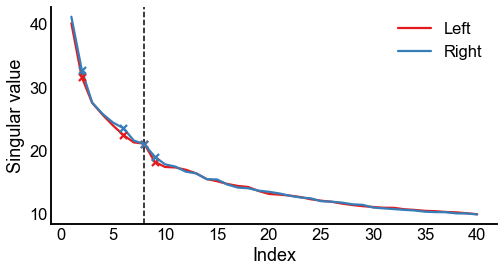

In [5]:


def screeplot(sing_vals, elbow_inds, color=None, ax=None, label=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.plot(range(1, len(sing_vals) + 1), sing_vals, color=color, label=label)
    plt.scatter(
        elbow_inds, sing_vals[elbow_inds - 1], marker="x", s=50, zorder=10, color=color
    )
    ax.set(ylabel="Singular value", xlabel="Index")
    return ax


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
screeplot(left_sing_vals, left_elbow_inds, color=palette["Left"], ax=ax, label="Left")
screeplot(
    right_sing_vals, right_elbow_inds, color=palette["Right"], ax=ax, label="Right"
)
ax.legend()
ax.axvline(n_components, color="black", linewidth=1.5, linestyle="--")
stashfig(f"screeplot-preprocess={preprocess}")

### Plot the latent positions without alignment
In the following figures, I usually focus on $d=3$ as the embedding dimension, as this
was a small dimension where alignment was non-trivial (not just a sign flip) and in
the original experiment we rejected the null hypothesis that the left and the right
came from the same distribution (see {doc}`./bilateral_symmetry`).

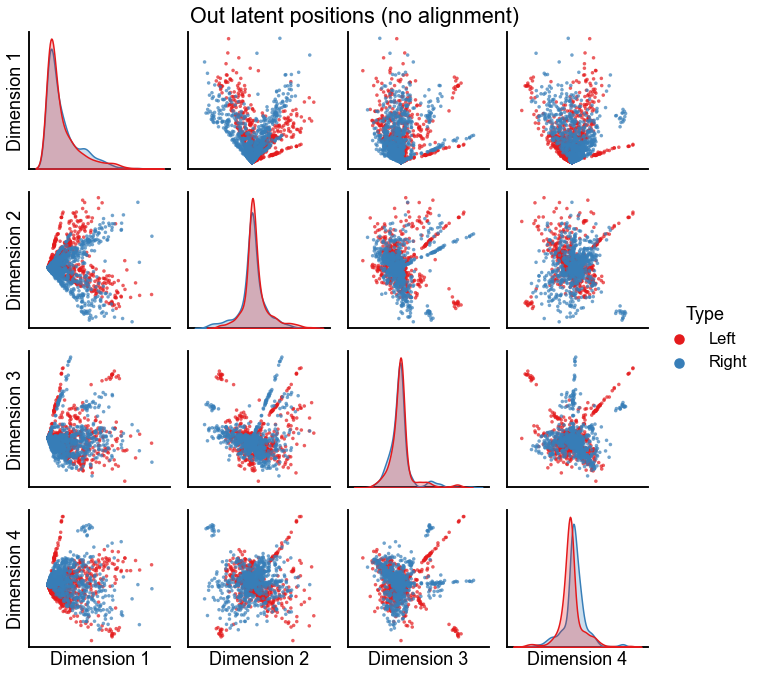

In [6]:


def plot_latents(left, right, title="", n_show=4):
    plot_data = np.concatenate([left, right], axis=0)
    labels = np.array(["Left"] * len(left) + ["Right"] * len(right))
    pg = pairplot(plot_data[:, :n_show], labels=labels, title=title)
    return pg


plot_latents(left_out, right_out, title="Out latent positions (no alignment)")
stashfig(f"out-latent-no-align-preprocess={preprocess}")

### Align the 3-dimensional out embeddings using known or predicted pairs

In [7]:


def run_alignments(X, Y, scale=False):
    X = X.copy()
    Y = Y.copy()
    if scale:
        X_norm = np.linalg.norm(X, ord="fro")
        Y_norm = np.linalg.norm(Y, ord="fro")
        avg_norms = (X_norm + Y_norm) / 2
        X = X * (avg_norms / X_norm)
        Y = Y * (avg_norms / Y_norm)
    op = OrthogonalProcrustes()
    X_trans_op = op.fit_transform(X, Y)
    sp = SeedlessProcrustes(init="custom", initial_Q=op.Q_)
    X_trans_sp = sp.fit_transform(X, Y)
    return X_trans_op, X_trans_sp


def calc_diff_norm(X, Y):
    return np.linalg.norm(X - Y, ord="fro")


n_components = 3  # this was a small dimension where we reject
op_known_left_out, sp_known_left_out = run_alignments(
    left_out[:, :n_components], right_out[:, :n_components]
)

op_pred_left_out, sp_pred_left_out = run_alignments(
    left_out[:, :n_components], right_out[perm_inds, :n_components]
)

op_diff_norm = calc_diff_norm(op_known_left_out, right_out[:, :n_components])
sp_diff_norm = calc_diff_norm(sp_known_left_out, right_out[:, :n_components])
print(f"Procrustes diff. norm using true pairs: {op_diff_norm:0.3f}")
print(f"Seedless Procrustes diff. norm using true pairs: {sp_diff_norm:0.3f}")

op_diff_norm = calc_diff_norm(op_pred_left_out, right_out[perm_inds, :n_components])
sp_diff_norm = calc_diff_norm(sp_pred_left_out, right_out[perm_inds, :n_components])
print(f"Procrustes diff. norm using predicted pairs: {op_diff_norm:0.3f}")
print(f"Seedless Procrustes diff. norm using predicted pairs: {sp_diff_norm:0.3f}")

Procrustes diff. norm using true pairs: 3.754
Seedless Procrustes diff. norm using true pairs: 3.799
Procrustes diff. norm using predicted pairs: 3.761
Seedless Procrustes diff. norm using predicted pairs: 3.806


### Plot the results of these two kinds of alignment using orthogonal Procrustes

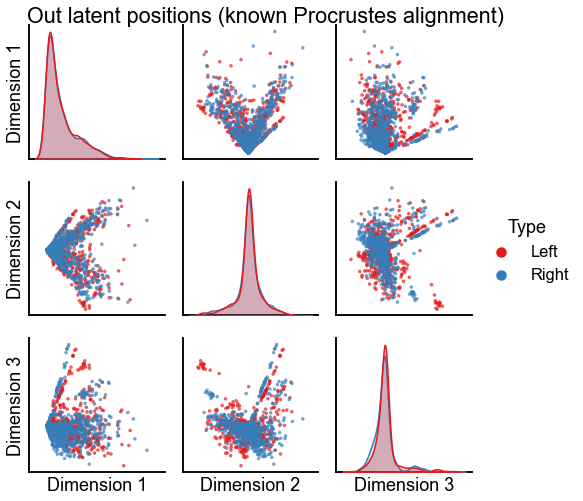

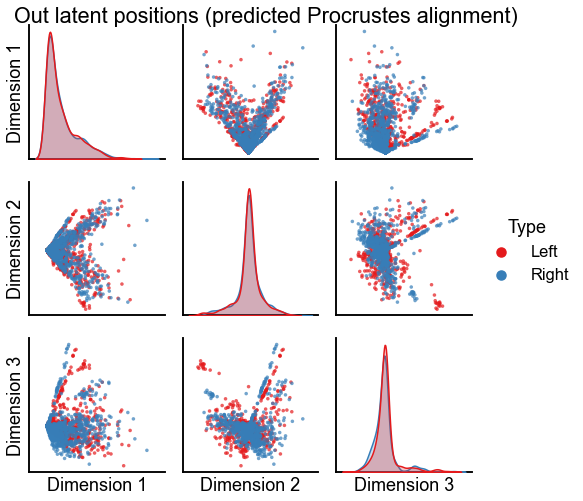

In [8]:
plot_latents(
    op_known_left_out,
    right_out[:, :n_components],
    "Out latent positions (known Procrustes alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-op-known-preprocess={preprocess}")

plot_latents(
    op_pred_left_out,
    right_out[perm_inds, :n_components],
    "Out latent positions (predicted Procrustes alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-op-pred-preprocess={preprocess}")

### Plot the results of these two kinds of alignment using seedless Procrustes

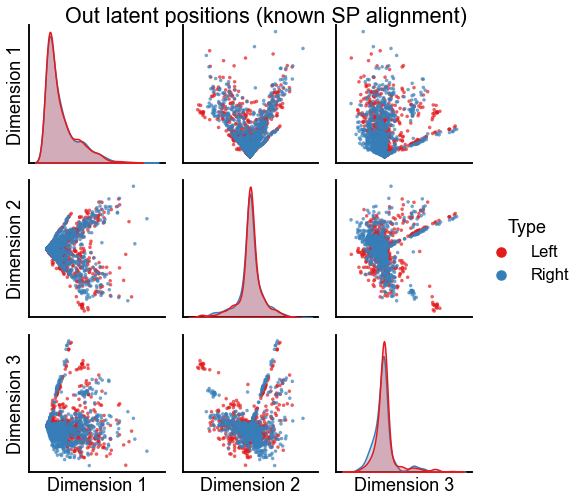

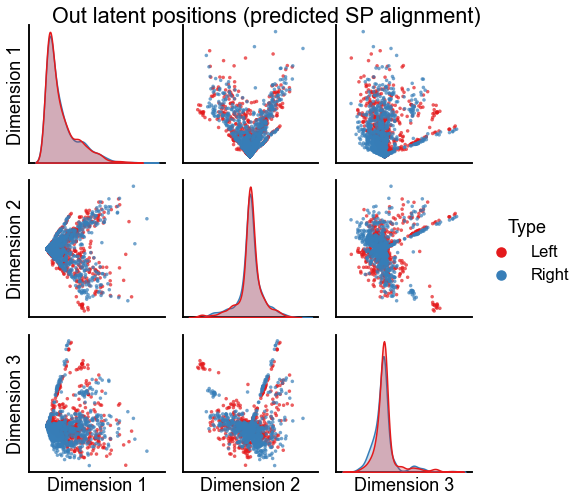

In [9]:
plot_latents(
    sp_known_left_out,
    right_out[:, :n_components],
    "Out latent positions (known SP alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-sp-known-preprocess={preprocess}")

plot_latents(
    sp_pred_left_out,
    right_out[perm_inds, :n_components],
    "Out latent positions (predicted SP alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-sp-pred-preprocess={preprocess}")

### Plot the results of aligning with seedless Procrustes using all dimension flip initializations
Perhaps the results above settled into a local minima since we were initializing seedless
Procrustes from the orthogonal procustes solution. Here we restart from all of the
$2^d$ possible dimension sign flips, and take the best solution over those.

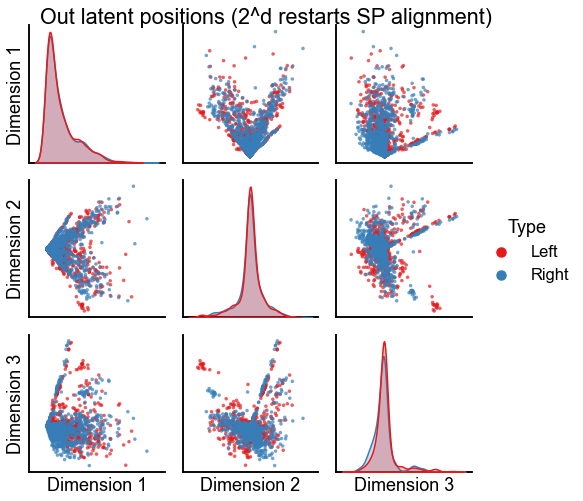

In [10]:
sp = SeedlessProcrustes(init="2d")
sp_all_left_out = sp.fit_transform(
    left_out[:, :n_components], right_out[:, :n_components]
)
plot_latents(
    sp_all_left_out,
    right_out[:, :n_components],
    "Out latent positions (2^d restarts SP alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-sp-2d-preprocess={preprocess}")

### Embed using Omni instead of ASE + align
Again, we use the try using either the known pairing or the best one that we have
predicted by graph matching.

Here we show the first 8 dimensions, because without doing any alignment post-embedding
we don't need to worry about what happens in $d=3$ vs $d=8$ etc.

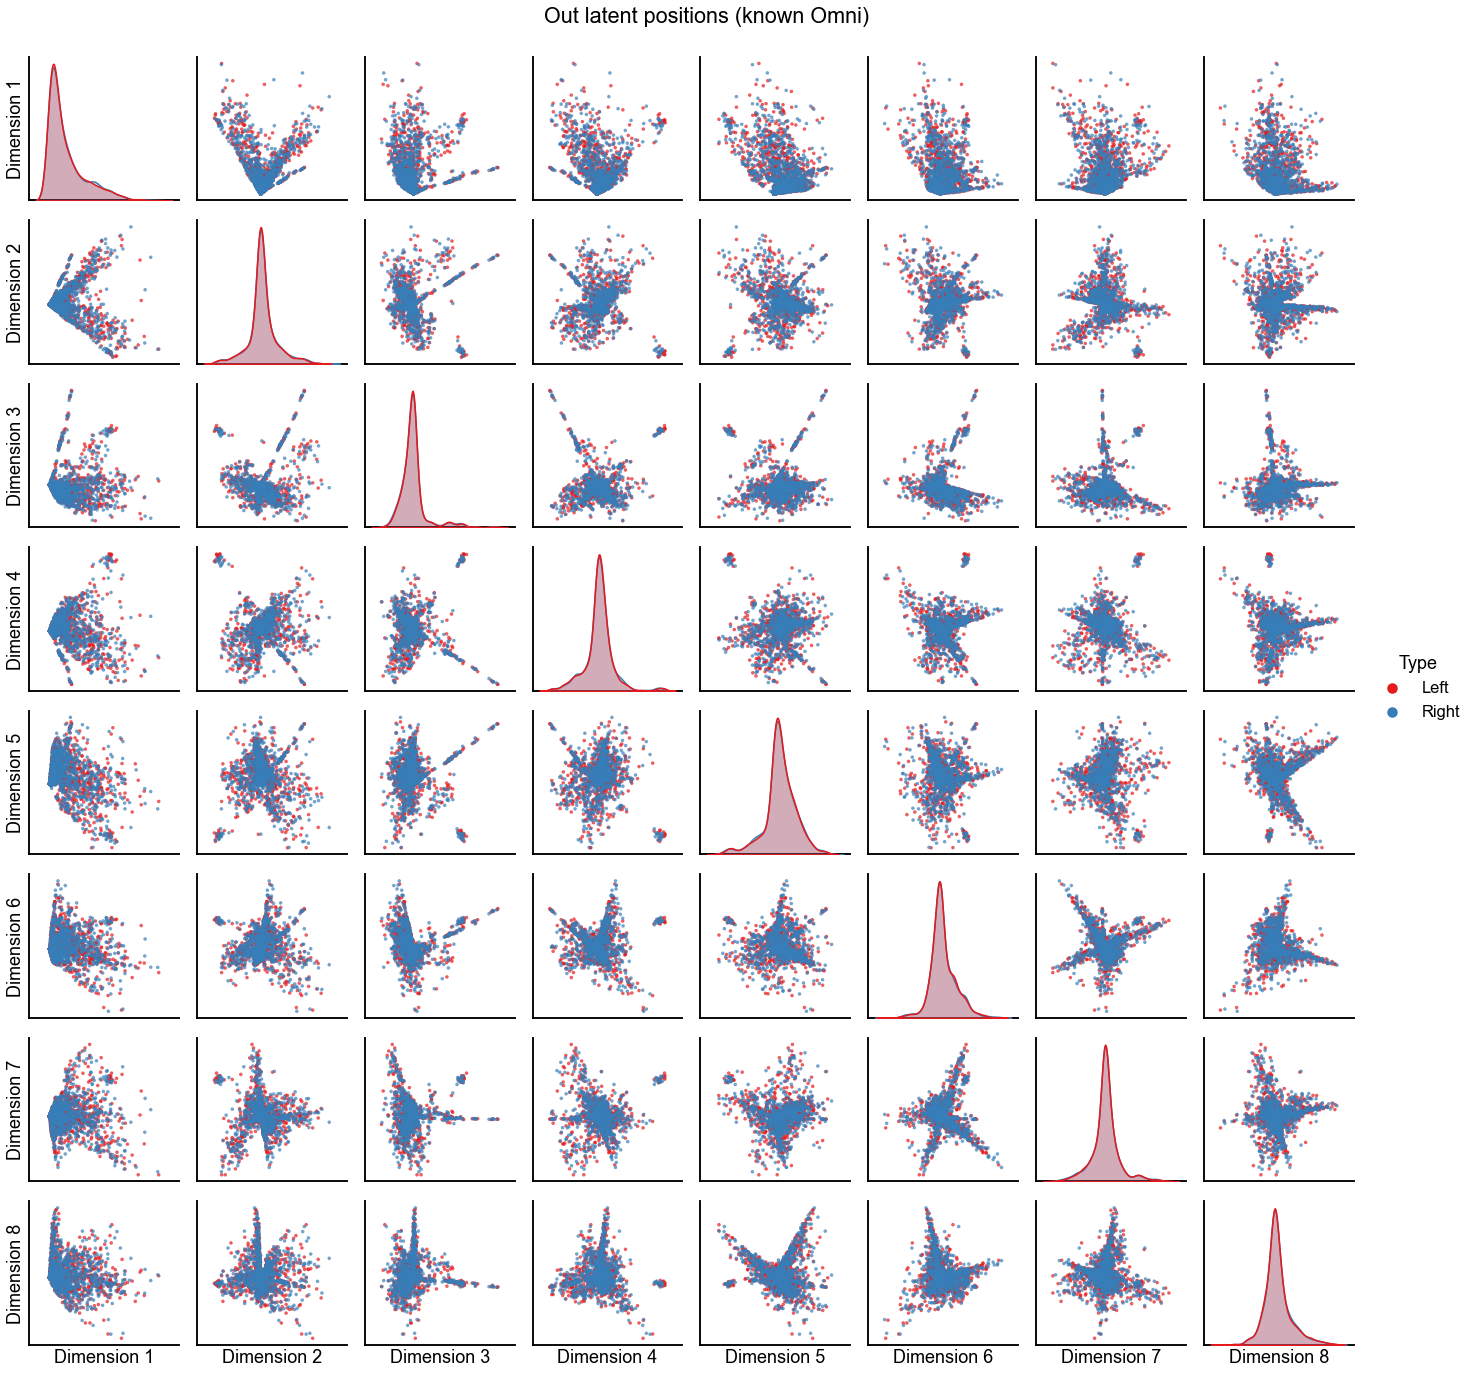

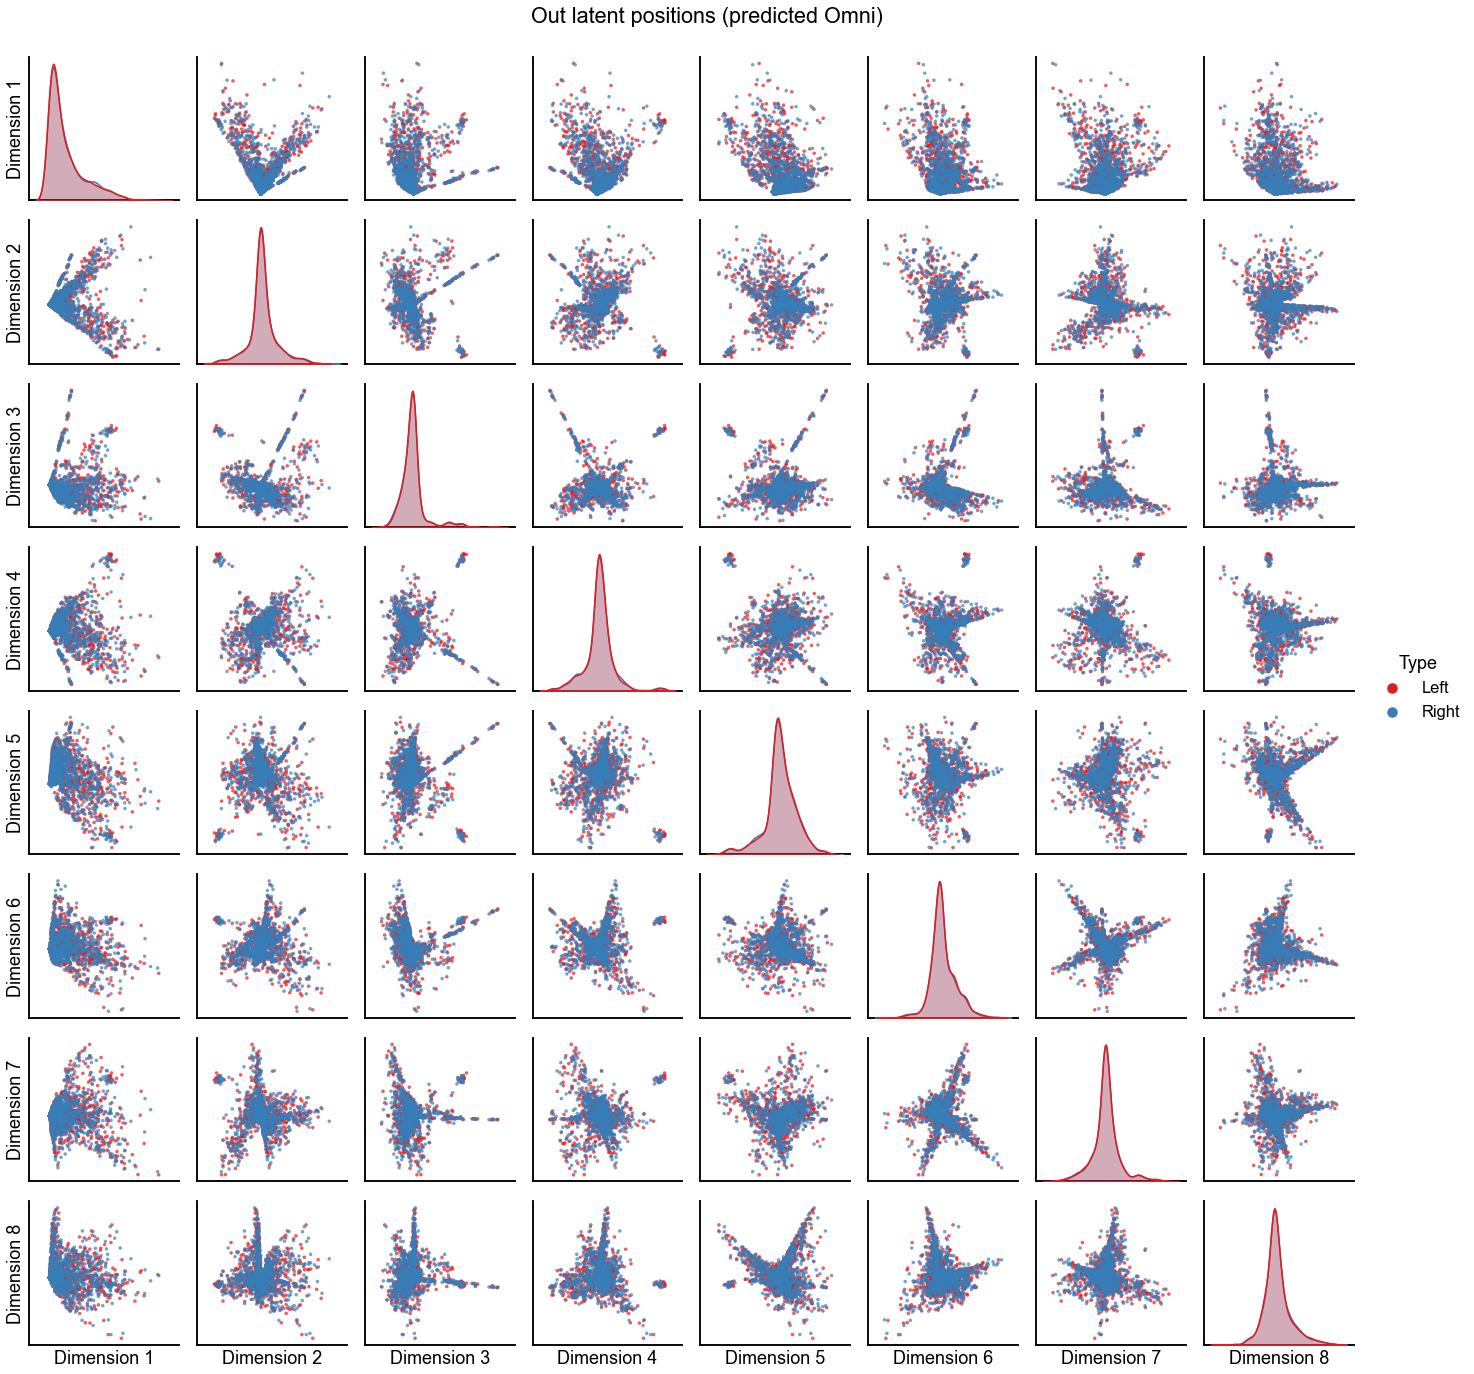

In [11]:
n_components = 8
omni = OmnibusEmbed(n_components=n_components)
out_latents, in_latents = omni.fit_transform([ll_adj_to_embed, rr_adj_to_embed])
omni_left_out = out_latents[0]
omni_right_out = out_latents[1]

plot_latents(
    omni_left_out,
    omni_right_out,
    "Out latent positions (known Omni)",
    n_show=n_components,
)

omni = OmnibusEmbed(n_components=n_components)
out_latents, in_latents = omni.fit_transform(
    [ll_adj_to_embed, rr_adj_to_embed[np.ix_(perm_inds, perm_inds)]]
)
omni_pred_left_out = out_latents[0]
omni_pred_right_out = out_latents[1]

plot_latents(
    omni_pred_left_out,
    omni_pred_right_out,
    "Out latent positions (predicted Omni)",
    n_show=n_components,
)

### Plot the left Omni embedding by rough cell type

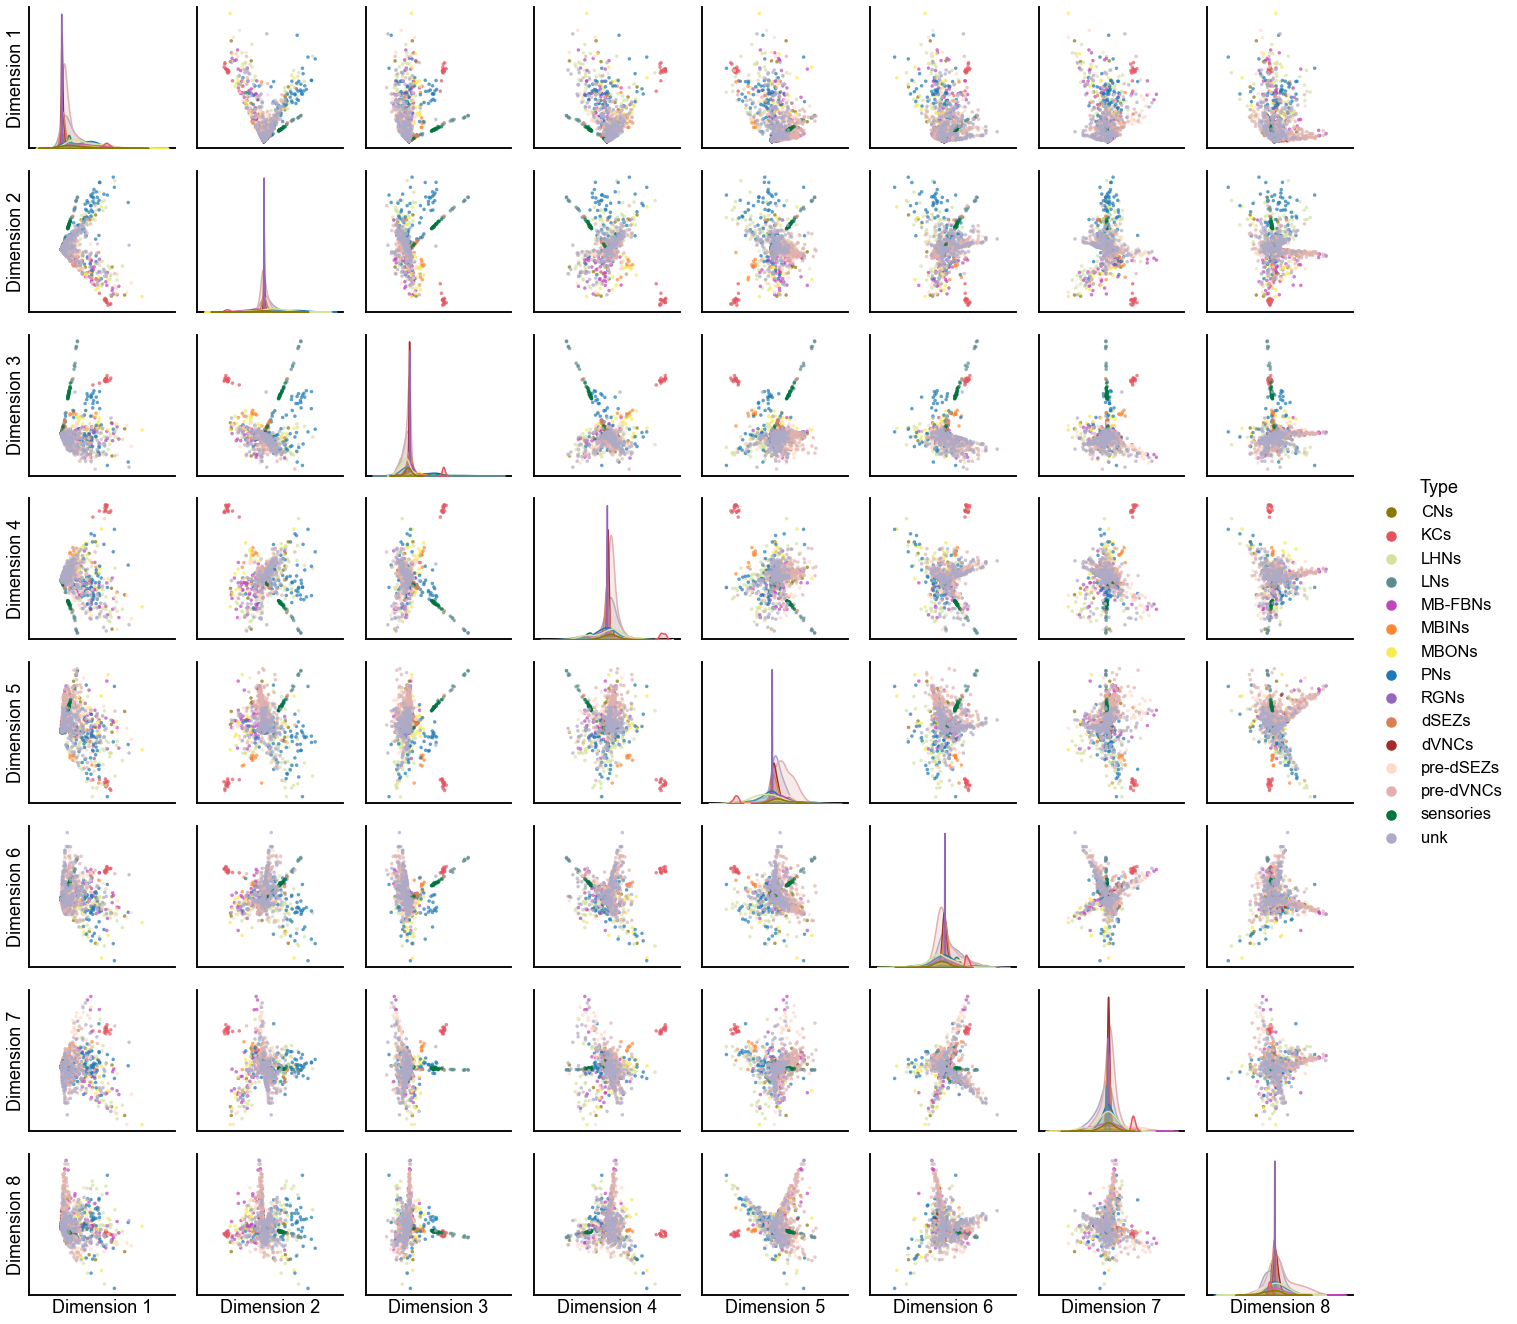

In [12]:
left_nodes = ll_mg.nodes.copy()
left_nodes = left_nodes.iloc[sort_inds]
left_nodes = left_nodes.iloc[lcc_inds]
pairplot(
    omni_left_out,
    labels=left_nodes["simple_group"].values,
    palette=load_palette(),
)

## What happens when we remove the Kenyon cells?
We can repeat much of the analysis from the above, but after removing the Kenyon
cells. These neurons are thought to be less bilaterally stereotyped than many other
neuron types. Note that most of the Kenyon cells were already not included in this
analysis since we started from only the paired neurons.

1129 in intersection of largest connected components.


(<Figure size 1080x504 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Left $\\to$ left'}>,
        <AxesSubplot:title={'center':'Right $\\to$ right'}>], dtype=object))

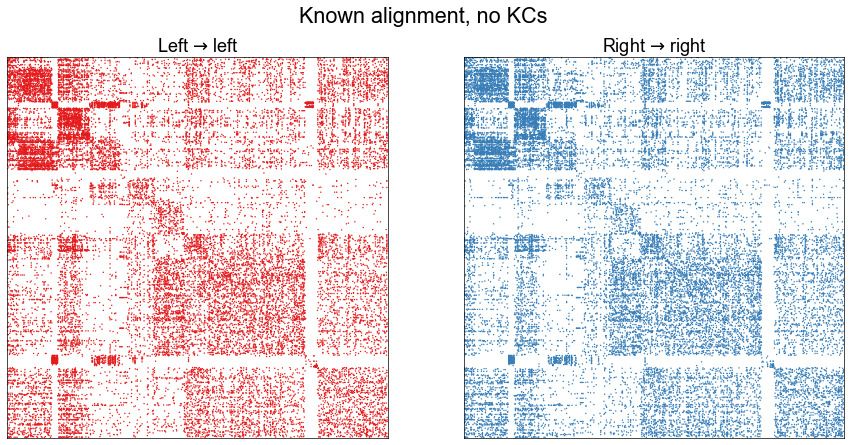

In [13]:
no_kc_mg = mg[mg.nodes["simple_group"] != "KCs"]

ll_mg, rr_mg, _, _ = no_kc_mg.bisect(paired=True)

ll_adj = ll_mg.sum.adj.copy()
rr_adj = rr_mg.sum.adj.copy()

nodes = ll_mg.nodes
nodes["_inds"] = range(len(nodes))
sorted_nodes = nodes.sort_values(["simple_group"])
sort_inds = sorted_nodes["_inds"]

ll_adj = ll_adj[np.ix_(sort_inds, sort_inds)]
rr_adj = rr_adj[np.ix_(sort_inds, sort_inds)]

adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

plot_adjs(ll_adj, rr_adj, title="Known alignment, no KCs")

In [14]:
ll_adj_to_embed, rr_adj_to_embed = preprocess_for_embed(ll_adj, rr_adj, preprocess)

left_out, left_in, left_sing_vals, left_elbow_inds = embed(
    ll_adj_to_embed, n_components=max_n_components
)
right_out, right_in, right_sing_vals, right_elbow_inds = embed(
    rr_adj_to_embed, n_components=max_n_components
)

### Align the 3-dimensional out embeddings using known pairs

In [15]:

n_components = 3  # this was a small dimension where we reject
op_known_left_out, sp_known_left_out = run_alignments(
    left_out[:, :n_components], right_out[:, :n_components]
)

op_diff_norm = calc_diff_norm(op_known_left_out, right_out[:, :n_components])
sp_diff_norm = calc_diff_norm(sp_known_left_out, right_out[:, :n_components])
print(f"Procrustes diff. norm using true pairs: {op_diff_norm:0.3f}")
print(f"Seedless Procrustes diff. norm using true pairs: {sp_diff_norm:0.3f}")

Procrustes diff. norm using true pairs: 3.324
Seedless Procrustes diff. norm using true pairs: 3.326


### Plot the results of alignment using orthogonal Procrustes

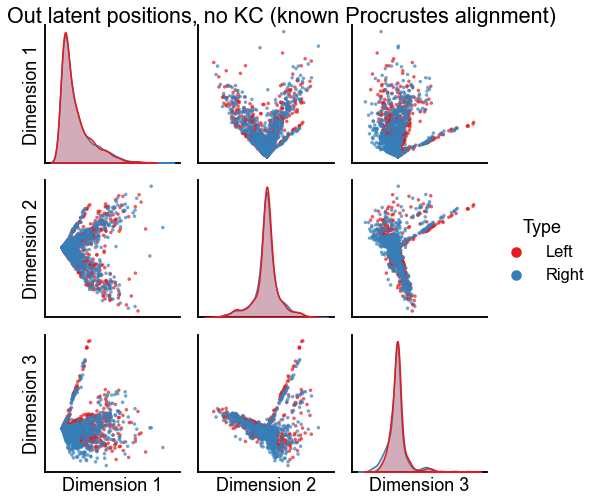

In [16]:
plot_latents(
    op_known_left_out,
    right_out[:, :n_components],
    "Out latent positions, no KC (known Procrustes alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-no-kc-op-known-preprocess={preprocess}")

### Plot the results of alignment using seedless Procrustes

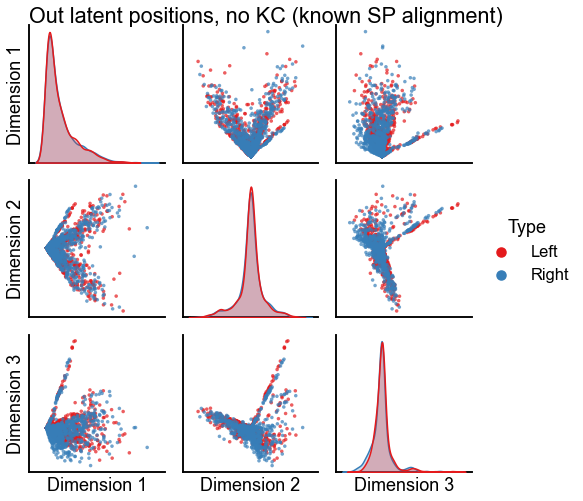

In [17]:
plot_latents(
    sp_known_left_out,
    right_out[:, :n_components],
    "Out latent positions, no KC (known SP alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-no-kc-sp-known-preprocess={preprocess}")

### Plot the embeddings using Omni with the known pair correspondence

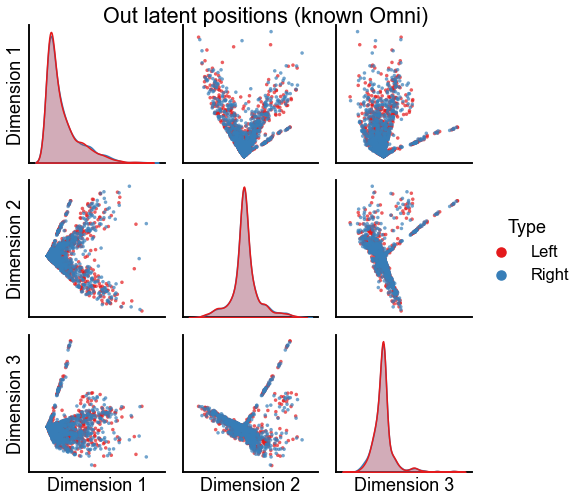

In [18]:
omni = OmnibusEmbed(n_components=n_components)
out_latents, in_latents = omni.fit_transform([ll_adj_to_embed, rr_adj_to_embed])
omni_left_out = out_latents[0]
omni_right_out = out_latents[1]

plot_latents(
    omni_left_out,
    omni_right_out,
    "Out latent positions (known Omni)",
    n_show=n_components,
)

## End

In [19]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:05:57.877405
Completed at 2021-03-22 09:33:34.012958
----
